

# DQN




In [ ]:
! pip install pettingzoo==1.22.3
! pip install multi_agent_ale_py
! pip install "autorom[accept-rom-license]"
! AutoROM --accept-license

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from pettingzoo.atari import space_invaders_v2
import cv2
from tqdm import tqdm

In [ ]:
class DQN(nn.Module):
    #Deep Q-Network: function approximator for the Q-table

    def __init__(self,action_size, seed, fc1_unit=64,
                 fc2_unit=64):
        """
        Initialize parameters and build model.
        Params
        =======
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_unit (int): Number of neurons in first hidden layer
            fc2_unit (int): Number of neurons in second hidden layer
        """
        super(DQN, self).__init__()  # calls __init__ method of nn.Module class
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(1, 32, 8, stride=4, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 19 * 8,512)  # flattening 3 frames of 128 kernels with size of 19x8
        self.fc2 = nn.Linear(512, action_size)  # 6 actions in space invaders

    def forward(self, state):
        """
        Maps a state to action-values.
        ---
        args:
            state: greyscale img as a tensor
        returns:
            q_values: array of length 6 corresponding to the action-values for each action given the input state
        """

        x = state.clone()
        x = x.view(-1, 1, 185, 95)
        # forward pass through conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor for the fc layers
        x = x.view(-1, 128 * 19 * 8)
        # forward pass through fc layers
        x = F.relu(self.fc1(x))
        x=self.fc2(x)

        return x

In [ ]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    #Fixed-size buffer to store experience tuples.

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience",field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experiences(state, action, reward, next_state, done))

    def sample(self):
        #Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.cat([e.state for e in experiences if e is not None])
        actions = torch.from_numpy(np.vstack([e.action for e in experiencesif e is not None])).long().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiencesif e is not None])).float().to(DEVICE)
        next_states = torch.cat([e.next_state for e in experiences if e is not None])
        dones = torch.from_numpy( np.vstack([e.done for e in experiencesif e is not None]).astype(np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        #Return the current size of internal memory.
        return len(self.memory)


class DQNAgent():
    #Interacts with and learns form the environment.

    def __init__(self,
                 action_size,
                 seed,
                 lr=1e-3,
                 gamma=0.999,
                 buffer_size=int(1e5),
                 batch_size=64,
                 update_every=20):
        """Initialize an Agent object.

        Params
        =======
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.action_size = action_size
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma

        # Q-Networks
        self.qnetwork_local = DQN(action_size, seed).to(DEVICE)
        self.qnetwork_target = DQN(action_size, seed).to(DEVICE)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        # Initialize time step (for updating every update_every steps)
        self.t_step = 0

    def preprocess_state(self, s):
        """
        preprocess space invader images before passing them through the network.
        - from rgb to grayscale
        - crop
        - to tensor
        """

        # transofrm image to grayscale
        def rgb2gray(rgb):
            return np.dot(rgb[..., :3],
                          [0.2989, 0.5870, 0.1140])[..., np.newaxis] / 255

        state = rgb2gray(s.copy())

        # create tensor and send to device
        state = torch.from_numpy(state[15:200, 30:125, :].transpose( 2, 0, 1)).float().unsqueeze(0).to(DEVICE)

        return state

    def step(self, state_, action, reward, next_state_, done):
        state = self.preprocess_state(state_.copy())
        next_state = self.preprocess_state(next_state_.copy())

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every self.update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get radom subset and learn
            if len(self.memory) > self.batch_size:
                experience = self.memory.sample()
                self.learn(experience)

    def act(self, state, eps=0):
        """Returns action for given state as per the policy
        =======
            state: current state
            eps: epsilon ued in epsilon-greedy action selection
        """
        def rgb2gray(rgb):
            """transofrm rgb image to grayscale"""
            return np.dot(rgb[..., :3],[0.2989, 0.5870, 0.1140])[..., np.newaxis]

        state = rgb2gray(state)

        # create tensor and send to DEVICE
        state = torch.from_numpy(state[15:200, 30:125, :].transpose( 2, 0, 1)).float().unsqueeze(0).to(DEVICE)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # e-greedy 
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            self.gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        criterion = torch.nn.MSELoss()
        self.qnetwork_local.train()
        self.qnetwork_target.eval()

        predicted_targets = self.qnetwork_local(states).gather(1, actions)

        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        labels = rewards + (self.gamma * labels_next * (1 - dones))

        loss = criterion(predicted_targets, labels).to(DEVICE)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

  0%|          | 0/150 [00:00<?, ?it/s]

Recording video to /content/test_uni_episode_0_gamma_0.999.avi


  1%|          | 1/150 [00:25<1:02:34, 25.20s/it]

	Episode 0 done in 3077 steps. With a score of 655


  1%|▏         | 2/150 [00:44<54:03, 21.92s/it]  

	Episode 1 done in 4901 steps. With a score of 900


  2%|▏         | 3/150 [00:57<43:42, 17.84s/it]

	Episode 2 done in 3077 steps. With a score of 760


  3%|▎         | 4/150 [01:19<47:01, 19.33s/it]

	Episode 3 done in 5585 steps. With a score of 925


  3%|▎         | 5/150 [01:40<48:28, 20.06s/it]

	Episode 4 done in 5317 steps. With a score of 980


  4%|▍         | 6/150 [01:52<41:34, 17.32s/it]

	Episode 5 done in 3085 steps. With a score of 940


  5%|▍         | 7/150 [02:07<39:35, 16.61s/it]

	Episode 6 done in 3953 steps. With a score of 755


  5%|▌         | 8/150 [02:16<33:29, 14.15s/it]

	Episode 7 done in 2205 steps. With a score of 710


  6%|▌         | 9/150 [02:24<28:42, 12.22s/it]

	Episode 8 done in 1937 steps. With a score of 635


  7%|▋         | 10/150 [02:41<31:27, 13.48s/it]

	Episode 9 done in 4265 steps. With a score of 780


  7%|▋         | 11/150 [02:51<28:44, 12.41s/it]

	Episode 10 done in 2513 steps. With a score of 685


  8%|▊         | 12/150 [03:03<28:17, 12.30s/it]

	Episode 11 done in 3097 steps. With a score of 725


  9%|▊         | 13/150 [03:17<29:13, 12.80s/it]

	Episode 12 done in 3593 steps. With a score of 710


  9%|▉         | 14/150 [03:44<39:08, 17.27s/it]

	Episode 13 done in 7165 steps. With a score of 1050


 10%|█         | 15/150 [04:00<38:06, 16.93s/it]

	Episode 14 done in 4213 steps. With a score of 835


 11%|█         | 16/150 [04:10<32:57, 14.76s/it]

	Episode 15 done in 2409 steps. With a score of 970


 11%|█▏        | 17/150 [04:24<32:01, 14.45s/it]

	Episode 16 done in 3561 steps. With a score of 765


 12%|█▏        | 18/150 [04:45<36:28, 16.58s/it]

	Episode 17 done in 5449 steps. With a score of 895


 13%|█▎        | 19/150 [05:05<38:07, 17.46s/it]

	Episode 18 done in 5213 steps. With a score of 980


 13%|█▎        | 20/150 [05:14<32:31, 15.01s/it]

	Episode 19 done in 2321 steps. With a score of 955


 14%|█▍        | 21/150 [05:24<29:05, 13.53s/it]

	Episode 20 done in 2553 steps. With a score of 890


 15%|█▍        | 22/150 [05:33<26:04, 12.22s/it]

	Episode 21 done in 2537 steps. With a score of 690


 15%|█▌        | 23/150 [05:47<26:37, 12.58s/it]

	Episode 22 done in 3409 steps. With a score of 880


 16%|█▌        | 24/150 [06:10<32:59, 15.71s/it]

	Episode 23 done in 5981 steps. With a score of 985


 17%|█▋        | 25/150 [06:25<32:20, 15.52s/it]

	Episode 24 done in 3821 steps. With a score of 840


 17%|█▋        | 26/150 [06:55<41:19, 20.00s/it]

	Episode 25 done in 7817 steps. With a score of 1220


 18%|█▊        | 27/150 [07:19<43:23, 21.17s/it]

	Episode 26 done in 6137 steps. With a score of 1060


 19%|█▊        | 28/150 [07:43<44:48, 22.04s/it]

	Episode 27 done in 6221 steps. With a score of 1255


 19%|█▉        | 29/150 [08:06<44:53, 22.26s/it]

	Episode 28 done in 6053 steps. With a score of 1090


 20%|██        | 30/150 [08:31<45:59, 23.00s/it]

	Episode 29 done in 6413 steps. With a score of 1535


 21%|██        | 31/150 [08:47<41:38, 21.00s/it]

	Episode 30 done in 3977 steps. With a score of 985


 21%|██▏       | 32/150 [08:55<33:33, 17.06s/it]

	Episode 31 done in 2161 steps. With a score of 655


 22%|██▏       | 33/150 [09:14<34:29, 17.69s/it]

	Episode 32 done in 4753 steps. With a score of 1175


 23%|██▎       | 34/150 [09:33<34:40, 17.94s/it]

	Episode 33 done in 4881 steps. With a score of 1005


 23%|██▎       | 35/150 [09:42<29:38, 15.46s/it]

	Episode 34 done in 2469 steps. With a score of 690


 24%|██▍       | 36/150 [10:10<36:25, 19.17s/it]

	Episode 35 done in 7129 steps. With a score of 1235


 25%|██▍       | 37/150 [10:19<30:15, 16.06s/it]

	Episode 36 done in 2141 steps. With a score of 675


 25%|██▌       | 38/150 [10:29<26:39, 14.28s/it]

	Episode 37 done in 2533 steps. With a score of 660


 26%|██▌       | 39/150 [10:44<26:48, 14.49s/it]

	Episode 38 done in 3833 steps. With a score of 830


 27%|██▋       | 40/150 [11:04<29:41, 16.20s/it]

	Episode 39 done in 5265 steps. With a score of 1120


 27%|██▋       | 41/150 [11:17<27:22, 15.07s/it]

	Episode 40 done in 3161 steps. With a score of 790


 28%|██▊       | 42/150 [11:26<23:50, 13.25s/it]

	Episode 41 done in 2145 steps. With a score of 660


 29%|██▊       | 43/150 [11:40<24:08, 13.54s/it]

	Episode 42 done in 3633 steps. With a score of 715


 29%|██▉       | 44/150 [11:52<23:08, 13.10s/it]

	Episode 43 done in 3061 steps. With a score of 750


 30%|███       | 45/150 [12:12<26:42, 15.27s/it]

	Episode 44 done in 5045 steps. With a score of 850


 31%|███       | 46/150 [12:21<22:52, 13.20s/it]

	Episode 45 done in 2289 steps. With a score of 685


 31%|███▏      | 47/150 [12:34<22:43, 13.24s/it]

	Episode 46 done in 3421 steps. With a score of 800


 32%|███▏      | 48/150 [12:45<21:16, 12.52s/it]

	Episode 47 done in 2705 steps. With a score of 740


 33%|███▎      | 49/150 [13:01<22:49, 13.56s/it]

	Episode 48 done in 4065 steps. With a score of 1095


 33%|███▎      | 50/150 [13:23<26:48, 16.08s/it]

	Episode 49 done in 5545 steps. With a score of 1075
Recording video to /content/test_uni_episode_50_gamma_0.999.avi


 34%|███▍      | 51/150 [13:32<23:12, 14.06s/it]

	Episode 50 done in 2157 steps. With a score of 645


 35%|███▍      | 52/150 [13:44<21:54, 13.41s/it]

	Episode 51 done in 3029 steps. With a score of 710


 35%|███▌      | 53/150 [14:02<23:49, 14.74s/it]

	Episode 52 done in 4637 steps. With a score of 840


 36%|███▌      | 54/150 [14:17<23:35, 14.75s/it]

	Episode 53 done in 3869 steps. With a score of 855


 37%|███▋      | 55/150 [14:25<20:17, 12.81s/it]

	Episode 54 done in 2029 steps. With a score of 645


 37%|███▋      | 56/150 [14:47<24:11, 15.44s/it]

	Episode 55 done in 5485 steps. With a score of 990


 38%|███▊      | 57/150 [15:18<31:22, 20.25s/it]

	Episode 56 done in 8297 steps. With a score of 1245


 39%|███▊      | 58/150 [15:27<26:05, 17.02s/it]

	Episode 57 done in 2373 steps. With a score of 675


 39%|███▉      | 59/150 [15:42<24:53, 16.42s/it]

	Episode 58 done in 3937 steps. With a score of 830


 40%|████      | 60/150 [15:52<21:31, 14.35s/it]

	Episode 59 done in 2393 steps. With a score of 670


 41%|████      | 61/150 [16:07<21:33, 14.54s/it]

	Episode 60 done in 3869 steps. With a score of 760


 41%|████▏     | 62/150 [16:16<19:01, 12.97s/it]

	Episode 61 done in 2317 steps. With a score of 645


 42%|████▏     | 63/150 [16:32<19:52, 13.70s/it]

	Episode 62 done in 4037 steps. With a score of 870


 43%|████▎     | 64/150 [16:43<18:41, 13.04s/it]

	Episode 63 done in 2977 steps. With a score of 950


 43%|████▎     | 65/150 [17:00<20:06, 14.20s/it]

	Episode 64 done in 4465 steps. With a score of 1085


 44%|████▍     | 66/150 [17:16<20:41, 14.78s/it]

	Episode 65 done in 4177 steps. With a score of 980


 45%|████▍     | 67/150 [17:45<26:12, 18.95s/it]

	Episode 66 done in 7373 steps. With a score of 1175


 45%|████▌     | 68/150 [18:04<25:45, 18.84s/it]

	Episode 67 done in 4965 steps. With a score of 1090


 46%|████▌     | 69/150 [18:25<26:21, 19.53s/it]

	Episode 68 done in 5417 steps. With a score of 1235


 47%|████▋     | 70/150 [18:40<24:25, 18.32s/it]

	Episode 69 done in 4069 steps. With a score of 1025


 47%|████▋     | 71/150 [19:02<25:25, 19.31s/it]

	Episode 70 done in 5489 steps. With a score of 875


 48%|████▊     | 72/150 [19:19<24:15, 18.66s/it]

	Episode 71 done in 4557 steps. With a score of 955


 49%|████▊     | 73/150 [19:41<25:11, 19.63s/it]

	Episode 72 done in 5629 steps. With a score of 965


 49%|████▉     | 74/150 [19:57<23:23, 18.47s/it]

	Episode 73 done in 4109 steps. With a score of 1060


 50%|█████     | 75/150 [20:10<21:12, 16.96s/it]

	Episode 74 done in 3417 steps. With a score of 715


 51%|█████     | 76/150 [20:26<20:26, 16.57s/it]

	Episode 75 done in 4061 steps. With a score of 935


 51%|█████▏    | 77/150 [20:47<22:03, 18.14s/it]

	Episode 76 done in 5581 steps. With a score of 890


 52%|█████▏    | 78/150 [21:14<24:45, 20.64s/it]

	Episode 77 done in 6857 steps. With a score of 1075


 53%|█████▎    | 79/150 [21:26<21:14, 17.96s/it]

	Episode 78 done in 2997 steps. With a score of 1135


 53%|█████▎    | 80/150 [21:46<21:51, 18.74s/it]

	Episode 79 done in 5209 steps. With a score of 1030


 54%|█████▍    | 81/150 [21:59<19:38, 17.08s/it]

	Episode 80 done in 3421 steps. With a score of 735


 55%|█████▍    | 82/150 [22:14<18:27, 16.29s/it]

	Episode 81 done in 3741 steps. With a score of 790


 55%|█████▌    | 83/150 [22:47<23:59, 21.49s/it]

	Episode 82 done in 8773 steps. With a score of 1480


 56%|█████▌    | 84/150 [23:03<21:36, 19.65s/it]

	Episode 83 done in 3825 steps. With a score of 980


 57%|█████▋    | 85/150 [23:17<19:39, 18.15s/it]

	Episode 84 done in 3813 steps. With a score of 1215


 57%|█████▋    | 86/150 [23:26<16:16, 15.26s/it]

	Episode 85 done in 2249 steps. With a score of 680


 58%|█████▊    | 87/150 [23:41<15:55, 15.17s/it]

	Episode 86 done in 3793 steps. With a score of 995


 59%|█████▊    | 88/150 [23:59<16:30, 15.97s/it]

	Episode 87 done in 4737 steps. With a score of 1360


 59%|█████▉    | 89/150 [24:07<13:55, 13.70s/it]

	Episode 88 done in 2029 steps. With a score of 615


 60%|██████    | 90/150 [24:15<12:02, 12.04s/it]

	Episode 89 done in 2249 steps. With a score of 710


 61%|██████    | 91/150 [24:39<15:15, 15.52s/it]

	Episode 90 done in 6105 steps. With a score of 1245


 61%|██████▏   | 92/150 [24:58<16:00, 16.56s/it]

	Episode 91 done in 4757 steps. With a score of 860


 62%|██████▏   | 93/150 [25:10<14:28, 15.23s/it]

	Episode 92 done in 3133 steps. With a score of 705


 63%|██████▎   | 94/150 [25:27<14:35, 15.64s/it]

	Episode 93 done in 4353 steps. With a score of 965


 63%|██████▎   | 95/150 [25:44<14:43, 16.06s/it]

	Episode 94 done in 4529 steps. With a score of 910


 64%|██████▍   | 96/150 [25:55<13:05, 14.54s/it]

	Episode 95 done in 2833 steps. With a score of 760


 65%|██████▍   | 97/150 [26:05<11:46, 13.34s/it]

	Episode 96 done in 2649 steps. With a score of 680


 65%|██████▌   | 98/150 [26:21<12:09, 14.04s/it]

	Episode 97 done in 4017 steps. With a score of 1015


 66%|██████▌   | 99/150 [26:45<14:26, 16.99s/it]

	Episode 98 done in 6037 steps. With a score of 1000


 67%|██████▋   | 100/150 [26:56<12:40, 15.21s/it]

	Episode 99 done in 2737 steps. With a score of 750
Recording video to /content/test_uni_episode_100_gamma_0.999.avi


 67%|██████▋   | 101/150 [27:31<17:11, 21.05s/it]

	Episode 100 done in 8189 steps. With a score of 1275


 68%|██████▊   | 102/150 [27:53<17:06, 21.38s/it]

	Episode 101 done in 5833 steps. With a score of 935


 69%|██████▊   | 103/150 [28:01<13:44, 17.55s/it]

	Episode 102 done in 2121 steps. With a score of 635


 69%|██████▉   | 104/150 [28:14<12:24, 16.18s/it]

	Episode 103 done in 3353 steps. With a score of 715


 70%|███████   | 105/150 [28:33<12:46, 17.03s/it]

	Episode 104 done in 4817 steps. With a score of 1060


 71%|███████   | 106/150 [28:44<11:12, 15.28s/it]

	Episode 105 done in 3005 steps. With a score of 780


 71%|███████▏  | 107/150 [29:00<10:55, 15.23s/it]

	Episode 106 done in 3817 steps. With a score of 800


 72%|███████▏  | 108/150 [29:11<09:54, 14.14s/it]

	Episode 107 done in 2997 steps. With a score of 935


 73%|███████▎  | 109/150 [29:24<09:26, 13.82s/it]

	Episode 108 done in 3305 steps. With a score of 825


 73%|███████▎  | 110/150 [29:42<09:54, 14.87s/it]

	Episode 109 done in 4553 steps. With a score of 885


 74%|███████▍  | 111/150 [29:51<08:30, 13.08s/it]

	Episode 110 done in 2185 steps. With a score of 670


 75%|███████▍  | 112/150 [30:09<09:16, 14.64s/it]

	Episode 111 done in 4845 steps. With a score of 945


 75%|███████▌  | 113/150 [30:31<10:25, 16.90s/it]

	Episode 112 done in 5669 steps. With a score of 1285


 76%|███████▌  | 114/150 [30:42<09:02, 15.07s/it]

	Episode 113 done in 2753 steps. With a score of 755


 77%|███████▋  | 115/150 [30:56<08:42, 14.93s/it]

	Episode 114 done in 3801 steps. With a score of 990


 77%|███████▋  | 116/150 [31:15<09:05, 16.05s/it]

	Episode 115 done in 5005 steps. With a score of 885


 78%|███████▊  | 117/150 [31:24<07:39, 13.91s/it]

	Episode 116 done in 2233 steps. With a score of 650


 79%|███████▊  | 118/150 [31:32<06:31, 12.23s/it]

	Episode 117 done in 2065 steps. With a score of 645


 79%|███████▉  | 119/150 [31:48<06:51, 13.28s/it]

	Episode 118 done in 4129 steps. With a score of 790


 80%|████████  | 120/150 [32:14<08:31, 17.04s/it]

	Episode 119 done in 6701 steps. With a score of 1095


 81%|████████  | 121/150 [32:37<09:10, 18.99s/it]

	Episode 120 done in 6121 steps. With a score of 1150


 81%|████████▏ | 122/150 [32:51<08:07, 17.42s/it]

	Episode 121 done in 3577 steps. With a score of 745


 82%|████████▏ | 123/150 [33:01<06:49, 15.17s/it]

	Episode 122 done in 2497 steps. With a score of 760


 83%|████████▎ | 124/150 [33:10<05:45, 13.27s/it]

	Episode 123 done in 2445 steps. With a score of 855


 83%|████████▎ | 125/150 [33:30<06:24, 15.40s/it]

	Episode 124 done in 5125 steps. With a score of 1075


 84%|████████▍ | 126/150 [33:39<05:19, 13.30s/it]

	Episode 125 done in 2141 steps. With a score of 710


 85%|████████▍ | 127/150 [33:56<05:33, 14.51s/it]

	Episode 126 done in 4525 steps. With a score of 865


 85%|████████▌ | 128/150 [34:26<07:00, 19.11s/it]

	Episode 127 done in 7781 steps. With a score of 1210


 86%|████████▌ | 129/150 [34:56<07:49, 22.38s/it]

	Episode 128 done in 7449 steps. With a score of 1520


 87%|████████▋ | 130/150 [35:17<07:21, 22.08s/it]

	Episode 129 done in 5749 steps. With a score of 865


 87%|████████▋ | 131/150 [35:29<06:01, 19.01s/it]

	Episode 130 done in 3025 steps. With a score of 820


 88%|████████▊ | 132/150 [35:39<04:53, 16.31s/it]

	Episode 131 done in 2533 steps. With a score of 745


 89%|████████▊ | 133/150 [35:54<04:31, 15.98s/it]

	Episode 132 done in 3973 steps. With a score of 805


 89%|████████▉ | 134/150 [36:05<03:50, 14.39s/it]

	Episode 133 done in 2709 steps. With a score of 655


 90%|█████████ | 135/150 [36:21<03:42, 14.82s/it]

	Episode 134 done in 4153 steps. With a score of 795


 91%|█████████ | 136/150 [36:41<03:51, 16.55s/it]

	Episode 135 done in 5237 steps. With a score of 1180


 91%|█████████▏| 137/150 [37:06<04:07, 19.01s/it]

	Episode 136 done in 6413 steps. With a score of 945


 92%|█████████▏| 138/150 [37:17<03:19, 16.59s/it]

	Episode 137 done in 2777 steps. With a score of 755


 93%|█████████▎| 139/150 [37:41<03:27, 18.88s/it]

	Episode 138 done in 6241 steps. With a score of 1320


 93%|█████████▎| 140/150 [38:06<03:25, 20.51s/it]

	Episode 139 done in 6393 steps. With a score of 1050


 94%|█████████▍| 141/150 [38:29<03:12, 21.41s/it]

	Episode 140 done in 6181 steps. With a score of 1190


 95%|█████████▍| 142/150 [38:45<02:38, 19.87s/it]

	Episode 141 done in 4005 steps. With a score of 870


 95%|█████████▌| 143/150 [39:03<02:15, 19.31s/it]

	Episode 142 done in 4741 steps. With a score of 920


 96%|█████████▌| 144/150 [39:15<01:41, 16.96s/it]

	Episode 143 done in 2929 steps. With a score of 805


 97%|█████████▋| 145/150 [39:32<01:25, 17.11s/it]

	Episode 144 done in 4621 steps. With a score of 850


 97%|█████████▋| 146/150 [39:44<01:01, 15.47s/it]

	Episode 145 done in 2969 steps. With a score of 685


 98%|█████████▊| 147/150 [39:59<00:45, 15.29s/it]

	Episode 146 done in 3905 steps. With a score of 960


 99%|█████████▊| 148/150 [40:17<00:32, 16.25s/it]

	Episode 147 done in 4617 steps. With a score of 905


 99%|█████████▉| 149/150 [40:34<00:16, 16.43s/it]

	Episode 148 done in 4469 steps. With a score of 875


100%|██████████| 150/150 [40:43<00:00, 16.29s/it]

	Episode 149 done in 2293 steps. With a score of 665
[655, 900, 760, 925, 980, 940, 755, 710, 635, 780, 685, 725, 710, 1050, 835, 970, 765, 895, 980, 955, 890, 690, 880, 985, 840, 1220, 1060, 1255, 1090, 1535, 985, 655, 1175, 1005, 690, 1235, 675, 660, 830, 1120, 790, 660, 715, 750, 850, 685, 800, 740, 1095, 1075, 645, 710, 840, 855, 645, 990, 1245, 675, 830, 670, 760, 645, 870, 950, 1085, 980, 1175, 1090, 1235, 1025, 875, 955, 965, 1060, 715, 935, 890, 1075, 1135, 1030, 735, 790, 1480, 980, 1215, 680, 995, 1360, 615, 710, 1245, 860, 705, 965, 910, 760, 680, 1015, 1000, 750, 1275, 935, 635, 715, 1060, 780, 800, 935, 825, 885, 670, 945, 1285, 755, 990, 885, 650, 645, 790, 1095, 1150, 745, 760, 855, 1075, 710, 865, 1210, 1520, 865, 820, 745, 805, 655, 795, 1180, 945, 755, 1320, 1050, 1190, 870, 920, 805, 850, 685, 960, 905, 875, 665]


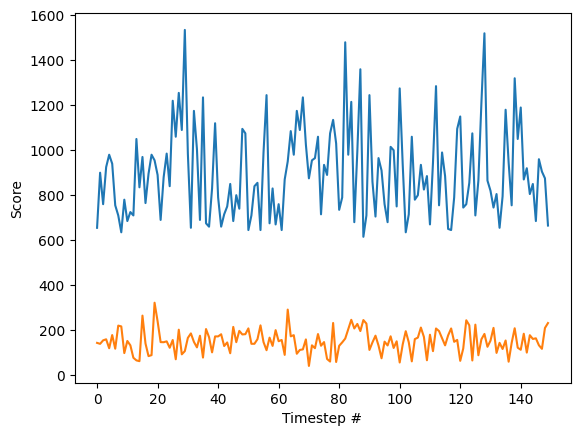

In [ ]:
def train(n_episodes=100,gamma=0.999):
    """
    Training the two DQN agents to play Space Invaders
    ---
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        gamma (float): gamma used for discounted rewards 
    Returns
    ======
        total_scores: list of the scores obtained in each episode
        total_discounted: list of the discounted scores obtained in each episode
    """
    eps = 0.2
    total_scores=[]
    total_discounted=[]

    for i_episode in tqdm(range(n_episodes)):
      env.reset()
      score = 0
      discounted_score=0
      count = 0
      #used to terminate the game when both agents enter a termination state
      both_fin=0

      cont=True

      #set up of video recording
      record_video=True
      video_writer = None
      video_prefix="test"
      if record_video and i_episode % 50 == 0:
            video_path = os.path.join(os.getcwd(), f"{video_prefix}_uni_episode_{i_episode}_gamma_{gamma}.avi")
            print(f"Recording video to {video_path}")
            frame_size = (160, 210)  # (width, height)
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)

      #where the agents play space invaders 
      while cont:

          for agent in env.agent_iter():
          
            observation, reward, termination, truncation,info = env.last()

            
            if termination or truncation:
              action=None
              both_fin+=1

            #As long as game is contiuing get the next action
            else:
              action =DQN_agents[agent].act(observation, eps) 
              both_fin=0

            #add curent state to the video of the game 
            if record_video:
                frame = env.render()
                if record_video and i_episode % 50 == 0 and video_writer is not None:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

            #as long as game is contiuing take the next action
            if both_fin!=2: 
              env.step(action)
              next_state, reward, termination, truncation,info = env.last()
              if action is not None:
                DQN_agents[agent].step(observation, action, reward, next_state, termination or truncation)
              observation = next_state
              score += reward
              discounted_score+=reward*(gamma**count)
            #go to next epsiode after game is over 
            else :
              env.reset()
              cont=False
              break;
            count+=1

      if video_writer is not None:    
        video_writer.release()    
      print('\tEpisode {} done in {} steps. With a score of {}'.format(
                i_episode, count,score))    
 
      total_scores.append(score)
      total_discounted.append(discounted_score)

    return total_scores,total_discounted



BUFFER_SIZE = 1000  # replay buffer size
BATCH_SIZE = 32  # minibatch size
GAMMA = 0.999  # discount factor
LR = 0.0005  # learning rate
UPDATE_EVERY = 30  # how often to update the target network
N_EPISODES = 150 #number of episodes to train on 

env = space_invaders_v2.env(render_mode="rgb_array", alternating_control=False, moving_shields=True, zigzaging_bombs=False, fast_bomb=False, invisible_invaders=False)

agent_1 = DQNAgent(action_size=6,seed=42, lr=LR,gamma=GAMMA,buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE,update_every=UPDATE_EVERY)
agent_2 = DQNAgent(action_size=6,seed=42,lr=LR,gamma=GAMMA,buffer_size=BUFFER_SIZE,batch_size=BATCH_SIZE,update_every=UPDATE_EVERY)
        

DQN_agents={"first_0":agent_1,"second_0":agent_2}

# train and get the scores
scores,d_scores = train(n_episodes=N_EPISODES)
print(scores)
# plot the rewards and discounted rewards
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores)
plt.plot(d_scores)
plt.ylabel('Score')
plt.xlabel('Timestep #')
plt.show()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/100 [00:00<?, ?it/s]

Recording video to /content/test_uni_episode_0_gamma_0.999.avi


  1%|          | 1/100 [00:05<08:24,  5.10s/it]

	Episode 0 done in 2472 steps. With a score of 880


  2%|▏         | 2/100 [00:13<11:48,  7.23s/it]

	Episode 1 done in 4676 steps. With a score of 1170


  3%|▎         | 3/100 [00:18<10:02,  6.22s/it]

	Episode 2 done in 2728 steps. With a score of 690


  4%|▍         | 4/100 [00:27<11:22,  7.11s/it]

	Episode 3 done in 4316 steps. With a score of 1130


  5%|▌         | 5/100 [00:40<14:27,  9.14s/it]

	Episode 4 done in 6808 steps. With a score of 1115


  6%|▌         | 6/100 [00:46<13:00,  8.30s/it]

	Episode 5 done in 3388 steps. With a score of 1230


  7%|▋         | 7/100 [00:52<11:45,  7.59s/it]

	Episode 6 done in 3588 steps. With a score of 795


  8%|▊         | 8/100 [01:00<11:45,  7.67s/it]

	Episode 7 done in 4112 steps. With a score of 790


  9%|▉         | 9/100 [01:10<12:26,  8.21s/it]

	Episode 8 done in 5288 steps. With a score of 890


 10%|█         | 10/100 [01:17<11:45,  7.84s/it]

	Episode 9 done in 3872 steps. With a score of 1005
Recording video to /content/test_uni_episode_10_gamma_0.999.avi


 11%|█         | 11/100 [01:22<10:25,  7.03s/it]

	Episode 10 done in 2368 steps. With a score of 935


 12%|█▏        | 12/100 [01:27<09:39,  6.58s/it]

	Episode 11 done in 2900 steps. With a score of 960


 13%|█▎        | 13/100 [01:35<10:01,  6.92s/it]

	Episode 12 done in 4236 steps. With a score of 1055


 14%|█▍        | 14/100 [01:40<08:56,  6.24s/it]

	Episode 13 done in 2480 steps. With a score of 1070


 15%|█▌        | 15/100 [01:45<08:38,  6.10s/it]

	Episode 14 done in 3360 steps. With a score of 1070


 16%|█▌        | 16/100 [01:51<08:10,  5.84s/it]

	Episode 15 done in 2500 steps. With a score of 705


 17%|█▋        | 17/100 [01:57<08:19,  6.01s/it]

	Episode 16 done in 3780 steps. With a score of 895


 18%|█▊        | 18/100 [02:03<08:09,  5.97s/it]

	Episode 17 done in 2940 steps. With a score of 995


 19%|█▉        | 19/100 [02:07<07:18,  5.41s/it]

	Episode 18 done in 2344 steps. With a score of 730


 20%|██        | 20/100 [02:15<08:22,  6.29s/it]

	Episode 19 done in 4528 steps. With a score of 1030
Recording video to /content/test_uni_episode_20_gamma_0.999.avi


 21%|██        | 21/100 [02:22<08:21,  6.35s/it]

	Episode 20 done in 3308 steps. With a score of 985


 22%|██▏       | 22/100 [02:30<08:56,  6.88s/it]

	Episode 21 done in 4344 steps. With a score of 900


 23%|██▎       | 23/100 [02:42<10:46,  8.39s/it]

	Episode 22 done in 6784 steps. With a score of 1370


 24%|██▍       | 24/100 [02:46<08:48,  6.96s/it]

	Episode 23 done in 2036 steps. With a score of 725


 25%|██▌       | 25/100 [03:03<12:33, 10.05s/it]

	Episode 24 done in 9796 steps. With a score of 1285


 26%|██▌       | 26/100 [03:07<10:19,  8.37s/it]

	Episode 25 done in 2288 steps. With a score of 715


 27%|██▋       | 27/100 [03:12<08:40,  7.12s/it]

	Episode 26 done in 2440 steps. With a score of 670


 28%|██▊       | 28/100 [03:20<09:10,  7.64s/it]

	Episode 27 done in 4764 steps. With a score of 890


 29%|██▉       | 29/100 [03:27<08:47,  7.43s/it]

	Episode 28 done in 3932 steps. With a score of 830


 30%|███       | 30/100 [03:33<08:05,  6.94s/it]

	Episode 29 done in 3048 steps. With a score of 1025
Recording video to /content/test_uni_episode_30_gamma_0.999.avi


 31%|███       | 31/100 [03:42<08:36,  7.49s/it]

	Episode 30 done in 4116 steps. With a score of 840


 32%|███▏      | 32/100 [03:51<08:58,  7.92s/it]

	Episode 31 done in 5368 steps. With a score of 1220


 33%|███▎      | 33/100 [03:56<07:47,  6.98s/it]

	Episode 32 done in 2284 steps. With a score of 965


 34%|███▍      | 34/100 [04:01<07:05,  6.44s/it]

	Episode 33 done in 3056 steps. With a score of 940


 35%|███▌      | 35/100 [04:13<08:42,  8.04s/it]

	Episode 34 done in 6640 steps. With a score of 1295


 36%|███▌      | 36/100 [04:23<09:14,  8.66s/it]

	Episode 35 done in 5572 steps. With a score of 1090


 37%|███▋      | 37/100 [04:33<09:37,  9.16s/it]

	Episode 36 done in 5700 steps. With a score of 890


 38%|███▊      | 38/100 [04:38<08:08,  7.87s/it]

	Episode 37 done in 2812 steps. With a score of 1155


 39%|███▉      | 39/100 [04:42<06:50,  6.73s/it]

	Episode 38 done in 2300 steps. With a score of 740


 40%|████      | 40/100 [04:47<06:15,  6.26s/it]

	Episode 39 done in 2492 steps. With a score of 655
Recording video to /content/test_uni_episode_40_gamma_0.999.avi


 41%|████      | 41/100 [04:55<06:39,  6.77s/it]

	Episode 40 done in 3956 steps. With a score of 805


 42%|████▏     | 42/100 [05:01<06:18,  6.53s/it]

	Episode 41 done in 3072 steps. With a score of 795


 43%|████▎     | 43/100 [05:06<05:43,  6.02s/it]

	Episode 42 done in 2796 steps. With a score of 760


 44%|████▍     | 44/100 [05:11<05:22,  5.76s/it]

	Episode 43 done in 2504 steps. With a score of 675


 45%|████▌     | 45/100 [05:14<04:39,  5.07s/it]

	Episode 44 done in 1944 steps. With a score of 630


 46%|████▌     | 46/100 [05:20<04:36,  5.11s/it]

	Episode 45 done in 3020 steps. With a score of 975


 47%|████▋     | 47/100 [05:27<05:05,  5.76s/it]

	Episode 46 done in 3784 steps. With a score of 885


 48%|████▊     | 48/100 [05:43<07:37,  8.81s/it]

	Episode 47 done in 9252 steps. With a score of 1300


 49%|████▉     | 49/100 [05:48<06:35,  7.75s/it]

	Episode 48 done in 2576 steps. With a score of 720


 50%|█████     | 50/100 [05:55<06:10,  7.40s/it]

	Episode 49 done in 3860 steps. With a score of 855
Recording video to /content/test_uni_episode_50_gamma_0.999.avi


 51%|█████     | 51/100 [06:05<06:47,  8.33s/it]

	Episode 50 done in 5028 steps. With a score of 915


 52%|█████▏    | 52/100 [06:12<06:11,  7.73s/it]

	Episode 51 done in 3356 steps. With a score of 880


 53%|█████▎    | 53/100 [06:22<06:48,  8.70s/it]

	Episode 52 done in 6384 steps. With a score of 1395


 54%|█████▍    | 54/100 [06:29<06:09,  8.04s/it]

	Episode 53 done in 3332 steps. With a score of 970


 55%|█████▌    | 55/100 [06:36<05:45,  7.68s/it]

	Episode 54 done in 3804 steps. With a score of 835


 56%|█████▌    | 56/100 [06:45<05:59,  8.18s/it]

	Episode 55 done in 5280 steps. With a score of 1070


 57%|█████▋    | 57/100 [06:57<06:44,  9.42s/it]

	Episode 56 done in 6972 steps. With a score of 1270


 58%|█████▊    | 58/100 [07:04<06:04,  8.68s/it]

	Episode 57 done in 3612 steps. With a score of 775


 59%|█████▉    | 59/100 [07:17<06:43,  9.83s/it]

	Episode 58 done in 7040 steps. With a score of 1320


 60%|██████    | 60/100 [07:23<05:48,  8.71s/it]

	Episode 59 done in 3588 steps. With a score of 1205
Recording video to /content/test_uni_episode_60_gamma_0.999.avi


 61%|██████    | 61/100 [07:33<05:55,  9.13s/it]

	Episode 60 done in 4776 steps. With a score of 905


 62%|██████▏   | 62/100 [07:37<04:48,  7.58s/it]

	Episode 61 done in 2276 steps. With a score of 765


 63%|██████▎   | 63/100 [07:45<04:40,  7.57s/it]

	Episode 62 done in 3964 steps. With a score of 1000


 64%|██████▍   | 64/100 [07:51<04:21,  7.27s/it]

	Episode 63 done in 3712 steps. With a score of 835


 65%|██████▌   | 65/100 [08:04<05:08,  8.80s/it]

	Episode 64 done in 7028 steps. With a score of 1300


 66%|██████▌   | 66/100 [08:12<04:51,  8.58s/it]

	Episode 65 done in 4384 steps. With a score of 1025


 67%|██████▋   | 67/100 [08:22<04:57,  9.02s/it]

	Episode 66 done in 5568 steps. With a score of 1180


 68%|██████▊   | 68/100 [08:26<04:00,  7.51s/it]

	Episode 67 done in 2268 steps. With a score of 735


 69%|██████▉   | 69/100 [08:33<03:53,  7.53s/it]

	Episode 68 done in 3984 steps. With a score of 825


 70%|███████   | 70/100 [08:37<03:15,  6.51s/it]

	Episode 69 done in 2364 steps. With a score of 790
Recording video to /content/test_uni_episode_70_gamma_0.999.avi


 71%|███████   | 71/100 [08:44<03:11,  6.62s/it]

	Episode 70 done in 3060 steps. With a score of 990


 72%|███████▏  | 72/100 [08:53<03:24,  7.31s/it]

	Episode 71 done in 5384 steps. With a score of 1210


 73%|███████▎  | 73/100 [08:58<02:58,  6.60s/it]

	Episode 72 done in 2344 steps. With a score of 710


 74%|███████▍  | 74/100 [09:04<02:47,  6.43s/it]

	Episode 73 done in 3548 steps. With a score of 765


 75%|███████▌  | 75/100 [09:11<02:44,  6.57s/it]

	Episode 74 done in 3564 steps. With a score of 750


 76%|███████▌  | 76/100 [09:24<03:22,  8.43s/it]

	Episode 75 done in 7332 steps. With a score of 1330


 77%|███████▋  | 77/100 [09:39<04:01, 10.52s/it]

	Episode 76 done in 8960 steps. With a score of 1345


 78%|███████▊  | 78/100 [09:48<03:37,  9.87s/it]

	Episode 77 done in 4476 steps. With a score of 1005


 79%|███████▉  | 79/100 [09:52<02:52,  8.22s/it]

	Episode 78 done in 2480 steps. With a score of 725


 80%|████████  | 80/100 [10:02<02:55,  8.79s/it]

	Episode 79 done in 5548 steps. With a score of 1145
Recording video to /content/test_uni_episode_80_gamma_0.999.avi


 81%|████████  | 81/100 [10:13<02:59,  9.44s/it]

	Episode 80 done in 5288 steps. With a score of 1195


 82%|████████▏ | 82/100 [10:19<02:28,  8.24s/it]

	Episode 81 done in 3172 steps. With a score of 1010


 83%|████████▎ | 83/100 [10:24<02:07,  7.51s/it]

	Episode 82 done in 2900 steps. With a score of 985


 84%|████████▍ | 84/100 [10:35<02:15,  8.49s/it]

	Episode 83 done in 6252 steps. With a score of 1515


 85%|████████▌ | 85/100 [10:41<01:57,  7.84s/it]

	Episode 84 done in 3436 steps. With a score of 770


 86%|████████▌ | 86/100 [10:50<01:52,  8.05s/it]

	Episode 85 done in 4604 steps. With a score of 1135


 87%|████████▋ | 87/100 [10:55<01:33,  7.22s/it]

	Episode 86 done in 3100 steps. With a score of 985


 88%|████████▊ | 88/100 [11:15<02:10, 10.91s/it]

	Episode 87 done in 11084 steps. With a score of 1330


 89%|████████▉ | 89/100 [11:19<01:37,  8.86s/it]

	Episode 88 done in 2288 steps. With a score of 1145


 90%|█████████ | 90/100 [11:28<01:28,  8.84s/it]

	Episode 89 done in 4728 steps. With a score of 1170
Recording video to /content/test_uni_episode_90_gamma_0.999.avi


 91%|█████████ | 91/100 [11:32<01:07,  7.51s/it]

	Episode 90 done in 2160 steps. With a score of 725


 92%|█████████▏| 92/100 [11:41<01:02,  7.86s/it]

	Episode 91 done in 4752 steps. With a score of 965


 93%|█████████▎| 93/100 [11:47<00:52,  7.50s/it]

	Episode 92 done in 3964 steps. With a score of 760


 94%|█████████▍| 94/100 [11:52<00:40,  6.74s/it]

	Episode 93 done in 2372 steps. With a score of 790


 95%|█████████▌| 95/100 [11:58<00:32,  6.49s/it]

	Episode 94 done in 3452 steps. With a score of 1005


 96%|█████████▌| 96/100 [12:08<00:30,  7.53s/it]

	Episode 95 done in 5476 steps. With a score of 1135


 97%|█████████▋| 97/100 [12:15<00:22,  7.38s/it]

	Episode 96 done in 3944 steps. With a score of 1040


 98%|█████████▊| 98/100 [12:20<00:13,  6.54s/it]

	Episode 97 done in 2292 steps. With a score of 725


 99%|█████████▉| 99/100 [12:24<00:05,  5.93s/it]

	Episode 98 done in 2584 steps. With a score of 790


100%|██████████| 100/100 [12:31<00:00,  7.51s/it]

	Episode 99 done in 3336 steps. With a score of 865


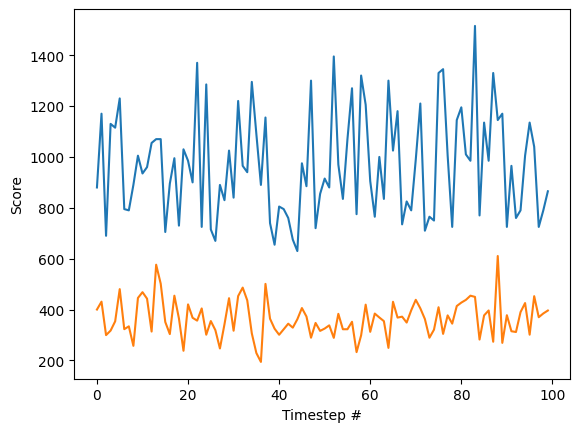

In [ ]:
def test(n_episodes=100,gamma=0.999):

    """
    Testing the two DQN agents on how they learned to play space invaders
    ---
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        gamma (float): gamma used for discounted rewards 
    Returns
    ======
        total_scores: list of the scores obtained in each episode
        total_discounted: list of the discounted scores obtained in each episode
        total_steps: list of steps it took to complete each episode
    """

    total_scores=[]
    total_discounted=[]
    total_steps=[]

    for i_episode in tqdm(range(n_episodes)):

      env.reset(seed=42)
      eps=0.2
      score = 0
      discounted_score=0
      count = 0
      #used to terminate the game when both agents enter a termination state
      both_fin=0
      cont=True

      #set up of video recording
      record_video=True
      video_writer = None
      video_prefix="test"
      if record_video and i_episode % 10 == 0:
            video_path = os.path.join(os.getcwd(), f"{video_prefix}_uni_episode_{i_episode}_gamma_{gamma}.avi")
            print(f"Recording video to {video_path}")
            frame_size = (160, 210)  # (width, height)
            video_writer = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'XVID'), env.metadata["render_fps"], frame_size)

      #where the agents play space invaders 
      while cont:

          for agent in env.agent_iter():
          
            observation, reward, termination, truncation,info = env.last()

            if termination or truncation:
              action=None
              both_fin=2
            else:
              action =DQN_agents[agent].act(observation,eps) 
              both_fin=0


            if record_video:
                frame = env.render()
                if record_video and i_episode % 10 == 0 and video_writer is not None:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

            if both_fin!=2: 
              env.step(action)
              next_state, reward, termination, truncation,info = env.last()
              observation = next_state
              score += reward
              discounted_score+=reward*(gamma**int(count/2))
            else :
              env.reset(seed=42)
              cont=False
              break;
            count+=1
      if video_writer is not None:    
        video_writer.release()    
      print('\tEpisode {} done in {} steps. With a score of {}'.format(
                i_episode, count,score))    
      total_steps.append(int(count/2))
      total_scores.append(score)
      total_discounted.append(discounted_score)

    return total_scores,total_discounted,total_steps

N_EPISODES = 100

# test and get the rewards,discounted rewards, and number of steps
ep_total_rewards,ep_total_rewards_discunted,ep_num_of_steps = test(n_episodes=N_EPISODES)

# plot the rewards
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(ep_total_rewards)
plt.plot(ep_total_rewards_discunted)
plt.ylabel('Score')
plt.xlabel('Timestep #')
plt.show()

In [ ]:
#save testing results to an np array
DQN_data=np.array([ep_total_rewards,ep_total_rewards_discunted,ep_num_of_steps])
np.save("DQN_updated",DQN_data)